In [15]:
import json
import pandas as pd

DATA_PATH = "./data/additional_datas.json"

with open(DATA_PATH, "r") as fichier:
    data = json.load(fichier)


df = pd.DataFrame.from_dict(data, orient='index')
df = df.stack().reset_index(level=1, drop=True).reset_index()
df.columns = ['Label', 'Text']
df = df[['Text', 'Label']]

df.head()

,Text,Label
0,The mayor announced a new initiative to improv...,Politics
1,The senator is facing criticism for her stance...,Politics
2,The upcoming election has sparked intense deba...,Politics
3,The governor unveiled a new plan to boost loca...,Politics
4,The congressman is under scrutiny for his comm...,Politics


In [16]:
df['Label'].unique()

array(['Politics', 'Health', 'Finance', 'Travel', 'Food', 'Education',
       'Environment', 'Fashion', 'Science', 'Sports', 'Technology',
       'Entertainment'], dtype=object)

Predicting labels: 100%|██████████| 1140/1140 [29:35<00:00,  1.56s/it]


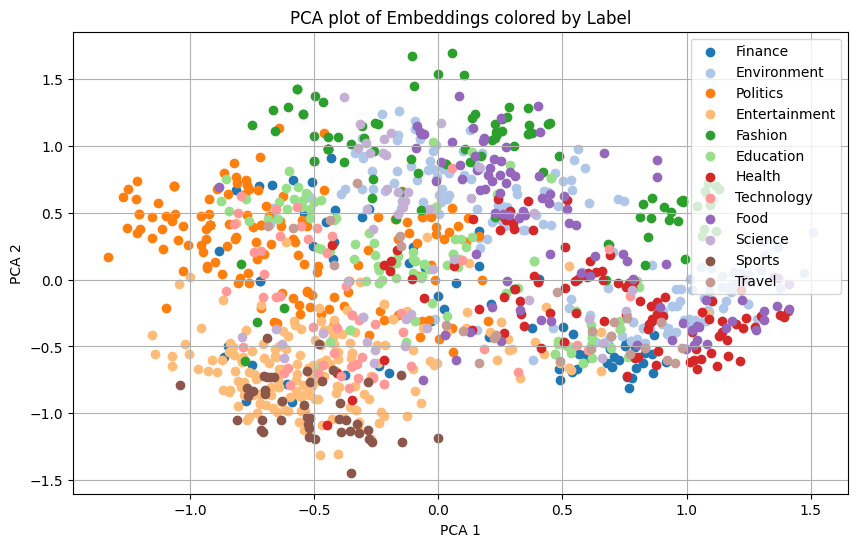

Predicted labels saved to 'predicted_labels.csv'


In [21]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def cosine_similarity_vector(a, b):
    return cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0][0]

# Function to predict label based on closest embedding
def predict_label(input_string, dataset_embeddings, dataset_labels, model, tokenizer):
    # Tokenize input string
    input_tokens = tokenizer(input_string, return_tensors='pt', padding=True, truncation=True)
    
    # Compute token embeddings for input string
    with torch.no_grad():
        model_output = model(**input_tokens.to(device))
    input_embedding = mean_pooling(model_output, input_tokens['attention_mask'].to(device)).cpu().numpy()

    # Calculate cosine similarity between input embedding and dataset embeddings
    similarities = [cosine_similarity_vector(input_embedding, emb) for emb in dataset_embeddings]

    # Find the highest similarity score for each label
    proximity_scores = {}
    for label, similarity in zip(dataset_labels, similarities):
        if label not in proximity_scores or similarity > proximity_scores[label]:
            proximity_scores[label] = similarity
    
    # Get the label with the highest similarity score
    predicted_label = max(proximity_scores, key=proximity_scores.get)
    
    # Return the dictionary of highest similarity scores for each label along with the predicted label
    return proximity_scores, predicted_label, input_embedding
    
# Load model from HuggingFace Hub
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').to(device)

# Sentences and corresponding labels
dataset_sentences = list(df['Text'])
dataset_labels = list(df['Label'])

# Tokenize and compute embeddings for dataset sentences
encoded_inputs = tokenizer(dataset_sentences, return_tensors='pt', padding=True, truncation=True).to(device)
with torch.no_grad():
    model_outputs = model(**encoded_inputs)
dataset_embeddings = mean_pooling(model_outputs, encoded_inputs['attention_mask'].to(device)).cpu().numpy()

# Read input strings from a text file
input_file = "./data/test_shuffle.txt"
with open(input_file, "r") as f:
    input_sentences = f.readlines()

# Predict label for each input string and store results in a DataFrame
results = []
confidence_threshold = 0.9
labels = []
with tqdm(total=len(input_sentences), desc="Predicting labels") as pbar:
    for i, input_string in enumerate(input_sentences):
        input_string = input_string.strip()  # Remove leading/trailing whitespaces
        proximity_scores, predicted_label, input_embedding = predict_label(input_string, dataset_embeddings, dataset_labels, model, tokenizer)
                
        results.append((i, predicted_label, input_embedding.flatten()))
        pbar.update(1)

# Convert results to DataFrame
df2 = pd.DataFrame(results, columns=['ID', 'Label', 'Embeddings'])

embeddings = np.array(df2['Embeddings'].tolist())

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Add PCA results to DataFrame
df2['PCA1'] = pca_result[:, 0]
df2['PCA2'] = pca_result[:, 1]

cmap = plt.get_cmap('tab20')
num_labels = len(df2['Label'].unique())
colors = [cmap(i) for i in range(num_labels)]

# Plotting
plt.figure(figsize=(10, 6))

# Plot each label separately
for label, color in zip(df2['Label'].unique(), colors):
    plt.scatter(df2[df2['Label'] == label]['PCA1'], 
                df2[df2['Label'] == label]['PCA2'], 
                c=[color], 
                label=label)

plt.title('PCA plot of Embeddings colored by Label')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

# Save results to a CSV file
output_csv = "predicted_labels.csv"
df2.to_csv(output_csv, index=False)

print(f"Predicted labels saved to '{output_csv}'")


In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tqdm import tqdm

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def cosine_similarity_vector(a, b):
    return cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0][0]

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-MiniLM-L6-v2')

# Read input strings from a text file
input_file = "./data/test_shuffle.txt"
with open(input_file, "r") as f:
    input_sentences = f.readlines()

# Tokenize and compute embeddings for each input sentence
embeddings = []
with tqdm(total=len(input_sentences), desc="Computing embeddings") as pbar:
    for input_string in input_sentences:
        input_string = input_string.strip()  # Remove leading/trailing whitespaces
        
        # Tokenize input string
        input_tokens = tokenizer(input_string, return_tensors='pt', padding=True, truncation=True)
        
        # Compute token embeddings for input string
        with torch.no_grad():
            model_output = model(**input_tokens)
        input_embedding = mean_pooling(model_output, input_tokens['attention_mask']).numpy()
        
        embeddings.append(input_embedding.flatten())
        pbar.update(1)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot embeddings with cluster colors
plt.figure(figsize=(10, 6))
for cluster_label in range(max(cluster_labels) + 1):
    plt.scatter(reduced_embeddings[cluster_labels == cluster_label, 0], 
                reduced_embeddings[cluster_labels == cluster_label, 1], 
                label=f'Cluster {cluster_label}', alpha=0.5)
plt.title('Embeddings in 2D space with K-means clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Computing embeddings: 100%|██████████| 1140/1140 [00:11<00:00, 102.19it/s]


NameError: name 'cluster_labels' is not defined

<Figure size 1000x600 with 0 Axes>

Computing embeddings: 100%|██████████| 2815/2815 [01:50<00:00, 25.37it/s]


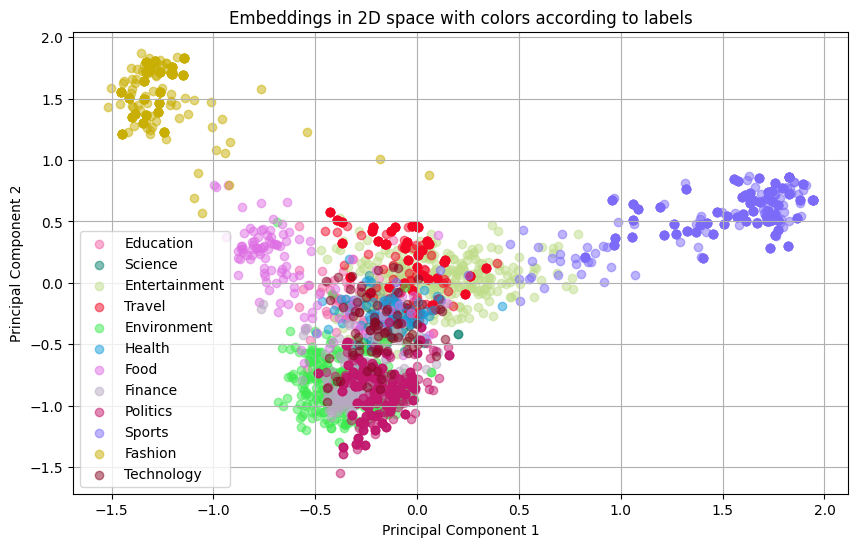

In [19]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from tqdm import tqdm

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')


# Tokenize and compute embeddings for each sentence in the DataFrame
embeddings = []
labels = []
with tqdm(total=len(df), desc="Computing embeddings") as pbar:
    for index, row in df.iterrows():
        input_string = row['Text'].strip()  # Assuming the column name for sentences is "sentence"
        
        # Tokenize input string
        input_tokens = tokenizer(input_string, return_tensors='pt', padding=True, truncation=True)
        
        # Compute token embeddings for input string
        with torch.no_grad():
            model_output = model(**input_tokens)
        input_embedding = mean_pooling(model_output, input_tokens['attention_mask']).numpy()
        
        embeddings.append(input_embedding.flatten())
        labels.append(row['Label'])  # Assuming the column name for labels is "label"
        pbar.update(1)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot embeddings with colors according to labels
label_to_color = {label: np.random.rand(3,) for label in set(labels)}  # Assign random colors to each unique label
plt.figure(figsize=(10, 6))
for label in set(labels):
    plt.scatter(reduced_embeddings[np.array(labels) == label, 0], 
                reduced_embeddings[np.array(labels) == label, 1], 
                label=label, color=label_to_color[label], alpha=0.5)
plt.title('Embeddings in 2D space with colors according to labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
